# Imports

In [ ]:
import nltk
nltk.download('names')
from nltk.corpus import names
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, MaxPooling1D, Conv1D, Dropout,Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
tf.random.set_seed(14)

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


# Load Dataset

In [ ]:
male=names.words('male.txt')
female=names.words('female.txt')
mlabel=['Male']*len(male)
flabel=['Female']*len(female)
male.extend(female)
data=male
mlabel.extend(flabel)
labels=mlabel

# Shuffling data

In [ ]:
c = list(zip(data, labels))
random.shuffle(c)
data, labels = zip(*c)
data=np.array(data)
labels=np.array(labels)
print(data)
print(labels)

['Lyndsie' 'Val' 'Fae' ... 'Giffer' 'Marisa' 'Elliot']
['Female' 'Male' 'Female' ... 'Male' 'Female' 'Male']


In [ ]:
mappings={0:'Female',1:'Male'}

# Visualisations

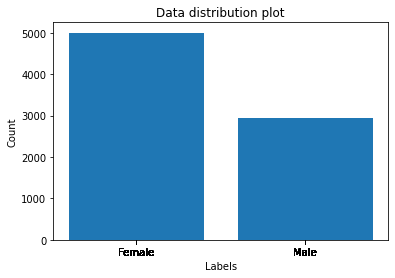

In [ ]:
fig,ax=plt.subplots()
lbl, counts = np.unique(labels, return_counts=True)
ax.bar(lbl, counts, align='center')
ax.set_xticks(labels)
ax.set_title('Data distribution plot')
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
plt.show()

# Preprocessing data

Label Encoder on labels

In [ ]:
labels

array(['Female', 'Male', 'Female', ..., 'Male', 'Female', 'Male'],
      dtype='<U6')

In [ ]:
labels=np.array([1 if lbl=='Male' else 0 for lbl in labels],dtype='float32')
labels

array([0., 1., 0., ..., 1., 0., 1.], dtype=float32)

Convert to lowercase

In [ ]:
lower=[x.lower() for x in data]
lower[:5]

['lyndsie', 'val', 'fae', 'willi', 'sutton']

Character level splitting

In [ ]:
chrSplit=[list(name) for name in lower]
chrSplit[:5]

[['l', 'y', 'n', 'd', 's', 'i', 'e'],
 ['v', 'a', 'l'],
 ['f', 'a', 'e'],
 ['w', 'i', 'l', 'l', 'i'],
 ['s', 'u', 't', 't', 'o', 'n']]

Word2Vec

In [ ]:
size=50
word2vec = Word2Vec(chrSplit,size=size,sg=1,min_count=1, workers = -1)
#model1.build_vocab(lower)
# train the model
#model1.train(lower,total_examples=model1.corpus_count,epochs=model1.iter)

#we create a dictionary with the word and its vector as the value
#vectors_model = dict(zip(model1.wv.index2word, model1.wv.syn0))
#model1['a']

Vectorize each character using word2vec

In [ ]:
wordVec=[[word2vec[chr] for chr in name] for name in chrSplit]


<ipython-input-10-8aff214e9d33>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wordVec=[[word2vec[chr] for chr in name] for name in chrSplit]


Padding with 0 for Word2Vec

In [ ]:
max_length=30
paddedData=[(name + [np.zeros(size,dtype='float32')]*max_length)[:max_length] for name in wordVec]
paddedData=np.array(paddedData).astype('float32')
print(paddedData[0])
print(paddedData.shape)

[[-0.00130932  0.00299776  0.00402307 ... -0.0046322   0.00621481
   0.00121459]
 [ 0.00917343  0.00150626  0.00341242 ... -0.00256579 -0.00139139
   0.00236537]
 [-0.00489728 -0.00567592  0.00949099 ... -0.00681717  0.00336296
  -0.00336932]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(7944, 30, 50)


Map char to numbers: (Not used)

In [ ]:
#data=[[ord(chr) for chr in name] for name in data]
#data[:5]

Padding with 0 (Not used)

In [ ]:
#max_length=30
#paddedData=[(name + [0]*max_length)[:max_length] for name in wordVec]
#paddedData=np.array(paddedData).astype('float32')
#print(paddedData)
#print(paddedData.shape)

Using Min-Max Scalar from sklearn (Not used)

In [ ]:
#scalar = MinMaxScaler()
#scaledData=scalar.fit_transform(paddedData)
#scaledData

# Splitting data into train test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(paddedData,labels, test_size=0.15, stratify=labels,random_state=42)
print('Shape of training data: ',X_train.shape)
print('Shape of training labels: ',y_train.shape)
print('Shape of testing data: ',X_test.shape)
print('Shape of testing labels: ',y_test.shape)


Shape of training data:  (6752, 30, 50)
Shape of training labels:  (6752,)
Shape of testing data:  (1192, 30, 50)
Shape of testing labels:  (1192,)


# Visualising training and test data splits

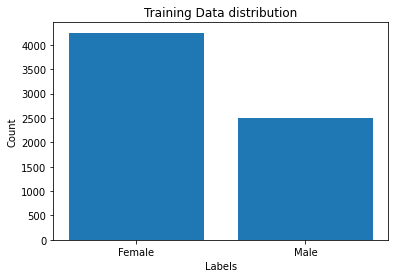

In [ ]:
fig,ax=plt.subplots()
lbl, counts = np.unique(y_train, return_counts=True)
ax.bar(lbl, counts, align='center')
ax.set_xticks([0,1])
ax.set_xticklabels(labels=['Female','Male'])
ax.set_title('Training Data distribution')
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
plt.show()

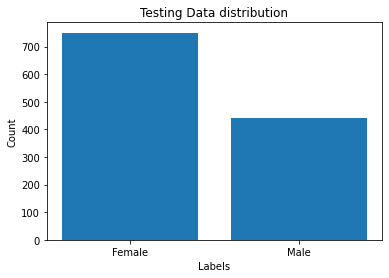

In [ ]:
fig,ax=plt.subplots()
lbl, counts = np.unique(y_test, return_counts=True)
ax.bar(lbl, counts, align='center')
ax.set_xticks([0,1])
ax.set_xticklabels(labels=['Female','Male'])

ax.set_title('Testing Data distribution')
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
plt.show()

# Model Evaluation helper function

In [ ]:
def plot_evaluation(y_test, y_pred):
    f1=f1_score(y_test, y_pred, average='binary')
    precision=precision_score(y_test, y_pred, average='binary')
    recall=recall_score(y_test, y_pred, average='binary')
    print('Precision is: ',precision)
    print('Recall is: ',recall)
    print('F1 Score is: ',f1)
    cm=confusion_matrix(y_test, y_pred) 
    print(cm)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_ylabel('Predicted labels');
    ax.set_xlabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Male', 'Female'])
    ax.yaxis.set_ticklabels(['Male', 'Female'])
    plt.show()

# Data training

### Task 1: 2 1d Convolution layers

In [ ]:
model=Sequential()
model.add(Conv1D(128,kernel_size=(3),padding='same',input_shape=(X_train.shape[1:]),activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Conv1D(128,kernel_size=(3),padding='same',activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512,activation='sigmoid'))
#model.add(Dropout(0.1))
model.add(Dense(2,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 30, 128)           19328     
                                                                 
 dropout_4 (Dropout)         (None, 30, 128)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 30, 128)           49280     
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 flatten_2 (Flatten)         (None, 3840)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1966592   
                                                                 
 dense_7 (Dense)             (None, 2)                

In [ ]:
adam=Adam(learning_rate=0.001)
rmsP=RMSprop(0.001)
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=50,
          batch_size=64,
          #callbacks=[early,reduceLOR],
          verbose=1)

Epoch 1/50
106/106 [==============================] - 1s 7ms/step - loss: 0.8156 - accuracy: 0.6056 - val_loss: 0.6659 - val_accuracy: 0.6292
Epoch 2/50
106/106 [==============================] - 1s 6ms/step - loss: 0.6689 - accuracy: 0.6200 - val_loss: 0.6920 - val_accuracy: 0.6292
Epoch 3/50
106/106 [==============================] - 1s 5ms/step - loss: 0.6664 - accuracy: 0.6237 - val_loss: 0.6939 - val_accuracy: 0.6292
Epoch 4/50
106/106 [==============================] - 1s 5ms/step - loss: 0.6665 - accuracy: 0.6280 - val_loss: 0.6596 - val_accuracy: 0.6292
Epoch 5/50
106/106 [==============================] - 1s 5ms/step - loss: 0.6681 - accuracy: 0.6238 - val_loss: 0.6668 - val_accuracy: 0.6292
Epoch 6/50
106/106 [==============================] - 1s 5ms/step - loss: 0.6655 - accuracy: 0.6300 - val_loss: 0.6593 - val_accuracy: 0.6292
Epoch 7/50
106/106 [==============================] - 1s 5ms/step - loss: 0.6626 - accuracy: 0.6296 - val_loss: 0.6611 - val_accuracy: 0.6292
Epoch 

In [ ]:
acc_conv=model.evaluate(X_test,y_test)

38/38 [==============================] - 0s 3ms/step - loss: 0.5347 - accuracy: 0.7307


38/38 [==============================] - 0s 2ms/step
Accuracy is:  0.7307047247886658
Precision is:  0.6268343815513627
Recall is:  0.6764705882352942
F1 Score is:  0.6507072905331882
[[572 178]
 [143 299]]


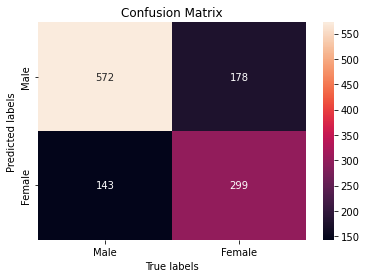

In [ ]:
predictions=model.predict(X_test)
print('Accuracy is: ',acc_conv[1])
y_pred = np.argmax(predictions,axis=1).astype('float32')
plot_evaluation(y_test,y_pred)

### Task 2: LSTM layer

In [ ]:
model=Sequential()
model.add(LSTM(128,input_shape=(X_train.shape[1:]),activation='relu'))
#model.add(Dropout(0.3))
#model.add(Flatten())
model.add(Dense(512,activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               91648     
                                                                 
 dense_12 (Dense)            (None, 512)               66048     
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 158,209
Trainable params: 158,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
adam=Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=20,
          batch_size=64,
          #callbacks=[early,reduceLOR],
          verbose=1)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


106/106 [==============================] - 41s 54ms/step - loss: 0.6624 - accuracy: 0.6284 - val_loss: 0.6625 - val_accuracy: 0.6292
Epoch 2/20
106/106 [==============================] - 6s 54ms/step - loss: 0.6598 - accuracy: 0.6296 - val_loss: 0.6347 - val_accuracy: 0.6292
Epoch 3/20
106/106 [==============================] - 6s 60ms/step - loss: 0.6471 - accuracy: 0.6296 - val_loss: 0.6150 - val_accuracy: 0.6292
Epoch 4/20
106/106 [==============================] - 7s 68ms/step - loss: 0.6347 - accuracy: 0.6321 - val_loss: 0.6252 - val_accuracy: 0.6728
Epoch 5/20
106/106 [==============================] - 6s 60ms/step - loss: 0.6150 - accuracy: 0.6534 - val_loss: 0.5765 - val_accuracy: 0.7215
Epoch 6/20
106/106 [==============================] - 6s 57ms/step - loss: 0.6043 - accuracy: 0.6777 - val_loss: 0.6760 - val_accuracy: 0.5327
Epoch 7/20
106/106 [==============================] - 6s 53ms/step - loss: 0.5951 - accuracy: 0.6773 - val_loss: 0.5449 - val_accuracy: 0.7290
Epoch 8/2

In [ ]:
acc_lstm=model.evaluate(X_test,y_test)

38/38 [==============================] - 0s 8ms/step - loss: 0.4795 - accuracy: 0.7819


38/38 [==============================] - 0s 7ms/step
Accuracy is:  0.781879186630249
Precision is:  0.7446236559139785
Recall is:  0.6266968325791855
F1 Score is:  0.6805896805896806
[[655  95]
 [165 277]]


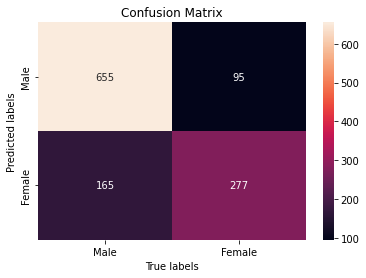

In [ ]:
predictions=model.predict(X_test)
print('Accuracy is: ',acc_lstm[1])
y_pred = np.where(predictions > 0.5 , 1., 0.).flatten().astype('float32')
plot_evaluation(y_test,y_pred)

### Task 3: LSTM and Conv

In [ ]:
model=Sequential()
model.add(LSTM(32,input_shape=(X_train.shape[1:]),activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(Conv1D(128,kernel_size=(3),padding='same',activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 32)            10624     
                                                                 
 dropout_8 (Dropout)         (None, 30, 32)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 30, 128)           12416     
                                                                 
 dropout_9 (Dropout)         (None, 30, 128)           0         
                                                                 
 flatten_4 (Flatten)         (None, 3840)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               1966592   
                                                                 
 dense_15 (Dense)            (None, 2)                

In [ ]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
adam=Adam(learning_rate=0.001)
rmsP=RMSprop(learning_rate=0.001)
#Best RMSP lr 0.001
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='rmsProp',
                  metrics=['accuracy'])

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=20,
          batch_size=32,
          #class_weight=classWeight,
          #callbacks=[early,reduceLOR],
          verbose=1)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


211/211 [==============================] - 6s 24ms/step - loss: 0.6311 - accuracy: 0.6468 - val_loss: 0.5652 - val_accuracy: 0.7206
Epoch 2/20
211/211 [==============================] - 5s 22ms/step - loss: 0.5574 - accuracy: 0.7094 - val_loss: 0.5164 - val_accuracy: 0.7559
Epoch 3/20
211/211 [==============================] - 6s 27ms/step - loss: 0.5337 - accuracy: 0.7367 - val_loss: 0.5019 - val_accuracy: 0.7592
Epoch 4/20
211/211 [==============================] - 5s 22ms/step - loss: 0.5204 - accuracy: 0.7402 - val_loss: 0.4997 - val_accuracy: 0.7542
Epoch 5/20
211/211 [==============================] - 5s 22ms/step - loss: 0.5112 - accuracy: 0.7456 - val_loss: 0.5040 - val_accuracy: 0.7475
Epoch 6/20
211/211 [==============================] - 5s 22ms/step - loss: 0.5065 - accuracy: 0.7496 - val_loss: 0.5114 - val_accuracy: 0.7508
Epoch 7/20
211/211 [==============================] - 5s 22ms/step - loss: 0.4935 - accuracy: 0.7657 - val_loss: 0.4906 - val_accuracy: 0.7576
Epoch 8/20

In [ ]:
acc_ConvLSTM=model.evaluate(X_test,y_test)

38/38 [==============================] - 0s 7ms/step - loss: 0.4594 - accuracy: 0.8020


38/38 [==============================] - 0s 6ms/step
Accuracy is:  0.8020133972167969
Precision is:  0.7229437229437229
Recall is:  0.755656108597285
F1 Score is:  0.7389380530973451
[[622 128]
 [108 334]]


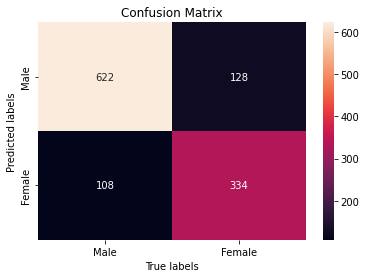

In [ ]:
predictions=model.predict(X_test)
print('Accuracy is: ',acc_ConvLSTM[1])
y_pred = np.argmax(predictions,axis=1).astype('float32')
plot_evaluation(y_test,y_pred)

# Comparison of approaches

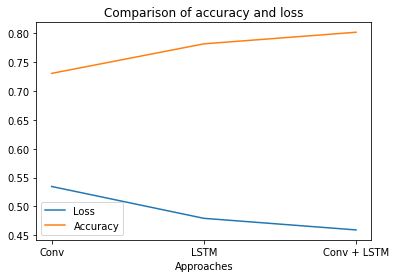

In [ ]:
valuePlot = [val for val in zip(acc_conv, acc_lstm, acc_ConvLSTM)]
x=range(len(valuePlot[0]))
fig,ax=plt.subplots()
ax.plot(x,valuePlot[0], label='Loss')
ax.plot(x,valuePlot[1], label='Accuracy')
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels=['Conv', 'LSTM', 'Conv + LSTM'])
ax.set_title('Comparison of accuracy and loss')
ax.set_xlabel('Approaches')
ax.legend()
plt.show()

# Testing

In [ ]:
name=['Laxmikanth']
lower=[x.lower() for x in name]
chars=[list(nm) for nm in lower]
wordVec=[[word2vec[chr] for chr in name] for name in chars]
max_length=30
paddedData=[(name + [np.zeros(size,dtype='float32')]*max_length)[:max_length] for name in wordVec]
paddedData=np.array(paddedData).astype('float32')
paddedData.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


(1, 30, 50)

In [ ]:
pred=model.predict(paddedData)
classes_x=np.argmax(pred,axis=1)
print('Female' if not classes_x else 'Male')
print('Probability: ',max(pred[0]))


1/1 [==============================] - 0s 19ms/step
Male
Probability:  0.838273
